# HoneyBee Workshop Part 5: Cancer Type Classification with Multimodal Embeddings

This notebook demonstrates how to use the multimodal embeddings generated in previous sessions to train machine learning classifiers for cancer type prediction. We'll compare performance across individual modalities and different fusion strategies.

**Important**: This notebook uses patient-level aggregated embeddings:
- WSI: Multiple slides per patient are averaged to create one embedding per patient
- Radiology: Multiple scans/slices per patient are hierarchically aggregated (slices→scans→patient)
- Clinical, Pathology, Molecular: Already one embedding per patient

This ensures proper patient-level alignment for multimodal fusion and classification.

## 🚀 Environment Setup

This notebook is designed to run in Google Colab. The following cells will set up the environment and install all necessary dependencies.

### Quick Start:
1. **Run all cells in order** - this notebook builds on data from notebook 04
2. **First time setup**: Allow 5-10 minutes for environment configuration
3. **Subsequent runs**: Should start much faster due to caching

### Requirements:
- Google Colab (recommended) or local Jupyter with GPU
- Google Drive account for data persistence
- Data from notebook 04 (patient-level aggregated embeddings)

In [ ]:
# Check if we're in Google Colab
try:
    import google.colab
    IN_COLAB = True
    print("🔍 Running in Google Colab")
except ImportError:
    IN_COLAB = False
    print("🔍 Running in local environment")

# Environment information
import sys
print(f"📍 Python version: {sys.version}")
print(f"📍 Current working directory: {'/content' if IN_COLAB else 'local'}")

if IN_COLAB:
    print("\n🏗️ Setting up Google Colab environment...")
    
    # Install system dependencies for medical imaging
    print("📦 Installing system dependencies...")
    !apt-get update -qq
    !apt-get install -y -qq openslide-tools tesseract-ocr
    
    # Mount Google Drive
    print("🔗 Mounting Google Drive...")
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    
    # Clone HoneyBee repository
    import os
    honeybee_dir = "/content/HoneyBee"
    if not os.path.exists(honeybee_dir):
        print("📥 Cloning HoneyBee repository...")
        !git clone https://github.com/maziyarpanahi/HoneyBee.git /content/HoneyBee
    else:
        print("✅ HoneyBee repository already exists")
    
    # Change to HoneyBee directory
    os.chdir(honeybee_dir)
    print(f"📂 Changed to directory: {os.getcwd()}")
    
    # Install uv for faster package installation
    !pip install -q uv
    
    # Install HoneyBee dependencies
    print("📦 Installing HoneyBee dependencies...")
    !uv pip install --system -q -r requirements.txt
    
    # Install additional packages for this notebook
    print("📦 Installing additional packages...")
    !uv pip install --system -q scikit-learn seaborn tqdm
    
    # Download NLTK data
    import nltk
    nltk.download('punkt', quiet=True)
    
    print("✅ Environment setup complete!")
    
    # Set up paths
    honeybee_path = "/content/HoneyBee"
    drive_data_path = "/content/drive/MyDrive/HoneyBee_Data"
    
else:
    print("⚠️ Local environment detected. Please ensure all dependencies are installed.")
    from pathlib import Path
    current_dir = Path.cwd()
    project_root = current_dir.parent.parent
    honeybee_path = str(project_root)
    drive_data_path = "embedding_cache"  # fallback to local cache

In [ ]:
# GPU Detection and Memory Optimization
import torch
import psutil
import gc

# Check GPU availability
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
    print(f"🚀 GPU Available: {gpu_name}")
    print(f"📊 GPU Memory: {gpu_memory:.1f} GB")
    
    # Clear GPU cache
    torch.cuda.empty_cache()
    print("🧹 GPU cache cleared")
else:
    print("⚠️ No GPU available - using CPU")

# Check system memory
memory_info = psutil.virtual_memory()
print(f"💾 System Memory: {memory_info.total / 1024**3:.1f} GB total, {memory_info.available / 1024**3:.1f} GB available")

# Memory optimization settings
if IN_COLAB:
    # Colab-specific optimizations
    print("\n🔧 Applying Colab optimizations...")
    
    # Set environment variables for better memory usage
    import os
    os.environ['TOKENIZERS_PARALLELISM'] = 'false'
    os.environ['OMP_NUM_THREADS'] = '2'
    
    # Configure matplotlib for Colab
    import matplotlib
    matplotlib.use('Agg')  # Use non-interactive backend
    
    # Memory management
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    print("✅ Colab optimizations applied")

print("\n🎯 System ready for multimodal cancer classification!")

## 1. Setup and Imports

Import necessary libraries and configure the environment for classification experiments.

In [ ]:
# Add HoneyBee to path
import sys
from pathlib import Path

# Set paths based on environment
if IN_COLAB:
    # Google Colab paths
    sys.path.insert(0, honeybee_path)
    print(f"📁 Added HoneyBee path: {honeybee_path}")
else:
    # Local development paths
    current_dir = Path.cwd()
    project_root = current_dir.parent.parent  # Go up two levels from examples/mayo to project root
    honeybee_path = str(project_root)
    if honeybee_path not in sys.path:
        sys.path.insert(0, honeybee_path)
    print(f"📁 Added HoneyBee path: {honeybee_path}")

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    f1_score,
    precision_score,
    recall_score
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# HuggingFace datasets
from datasets import load_dataset
from tqdm.auto import tqdm
import json
from datetime import datetime

# Visualization settings optimized for Colab
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)  # Default size for Colab
plt.rcParams['figure.dpi'] = 100  # Good resolution for Colab

# Set random seeds for reproducibility
np.random.seed(42)

print("✅ Imports successful")
print(f"  Working directory: {Path.cwd()}")
print(f"  HoneyBee path: {honeybee_path}")
print(f"  Data path: {drive_data_path}")

## 2. Load Pre-computed Embeddings from Previous Notebook

We'll use the embeddings and patient-modality mappings created in notebook 04. If you haven't run that notebook yet, please do so first.

In [ ]:
# Load embeddings from Google Drive (from notebook 04) or local cache
print("=" * 60)
print("📊 LOADING EMBEDDINGS FROM NOTEBOOK 04")
print("=" * 60)

import pickle
import os

# Define paths based on environment
if IN_COLAB:
    # Google Drive paths
    embeddings_dir = Path(drive_data_path) / "embeddings" / "patient_level"
    cache_summary_file = embeddings_dir / "cache_summary.json"
    
    # Check if Google Drive data exists
    if not embeddings_dir.exists():
        print("⚠️ Google Drive data directory not found!")
        print(f"Expected path: {embeddings_dir}")
        print("Please ensure you have run notebook 04 and data is saved to Google Drive.")
        
        # Create the directory structure
        embeddings_dir.mkdir(parents=True, exist_ok=True)
        
        # Try to use HuggingFace as fallback
        print("\n🔄 Attempting to load from HuggingFace as fallback...")
        use_huggingface = True
    else:
        use_huggingface = False
else:
    # Local development paths
    cache_dir = Path("embedding_cache")
    cache_summary_file = cache_dir / "cache_summary.json"
    embeddings_dir = cache_dir
    use_huggingface = not cache_summary_file.exists()

print(f"📁 Data directory: {embeddings_dir}")
print(f"📁 Cache summary file: {cache_summary_file}")

# Load embeddings
if not use_huggingface and cache_summary_file.exists():
    print("✅ Found patient-level embeddings from notebook 04!")
    
    # Load cache summary
    with open(cache_summary_file, 'r') as f:
        cache_summary = json.load(f)
    
    print(f"  Cache created: {cache_summary['creation_date']}")
    print(f"  Total patients: {cache_summary['total_patients']:,}")
    
    # Load patient-level embeddings
    print("\n📥 Loading patient-level embeddings...")
    
    # Clinical
    clinical_file = embeddings_dir / "clinical_embeddings.npy"
    if clinical_file.exists():
        clinical_embeddings = np.load(clinical_file)
        with open(embeddings_dir / "clinical_metadata.pkl", 'rb') as f:
            clinical_metadata = pickle.load(f)
        print(f"  ✅ Clinical: {clinical_embeddings.shape}")
    else:
        clinical_embeddings, clinical_metadata = None, None
        print("  ⚠️ Clinical embeddings not found")
    
    # Pathology
    pathology_file = embeddings_dir / "pathology_embeddings.npy"
    if pathology_file.exists():
        pathology_embeddings = np.load(pathology_file)
        with open(embeddings_dir / "pathology_metadata.pkl", 'rb') as f:
            pathology_metadata = pickle.load(f)
        print(f"  ✅ Pathology: {pathology_embeddings.shape}")
    else:
        pathology_embeddings, pathology_metadata = None, None
        print("  ⚠️ Pathology embeddings not found")
    
    # WSI (patient-level aggregated)
    wsi_file = embeddings_dir / "wsi_embeddings.npy"
    if wsi_file.exists():
        wsi_embeddings = np.load(wsi_file)
        with open(embeddings_dir / "wsi_metadata.pkl", 'rb') as f:
            wsi_metadata = pickle.load(f)
        print(f"  ✅ WSI (patient-level): {wsi_embeddings.shape}")
    else:
        wsi_embeddings, wsi_metadata = None, None
        print("  ⚠️ WSI embeddings not found")
    
    # Molecular
    molecular_file = embeddings_dir / "molecular_embeddings.npy"
    if molecular_file.exists():
        molecular_embeddings = np.load(molecular_file)
        with open(embeddings_dir / "molecular_metadata.pkl", 'rb') as f:
            molecular_metadata = pickle.load(f)
        print(f"  ✅ Molecular: {molecular_embeddings.shape}")
    else:
        molecular_embeddings, molecular_metadata = None, None
        print("  ⚠️ Molecular embeddings not found")
    
    # Radiology (patient-level aggregated)
    radiology_file = embeddings_dir / "radiology_embeddings.npy"
    if radiology_file.exists():
        radiology_embeddings = np.load(radiology_file)
        with open(embeddings_dir / "radiology_metadata.pkl", 'rb') as f:
            radiology_metadata = pickle.load(f)
        print(f"  ✅ Radiology (patient-level): {radiology_embeddings.shape}")
    else:
        radiology_embeddings, radiology_metadata = None, None
        print("  ⚠️ Radiology embeddings not found")
    
    # Load patient-modality mapping
    patient_map_file = embeddings_dir / "patient_modality_map.pkl"
    if patient_map_file.exists():
        with open(patient_map_file, 'rb') as f:
            patient_modality_map = pickle.load(f)
        print(f"\n  ✅ Patient-modality mapping: {len(patient_modality_map):,} patients")
    else:
        patient_modality_map = {}
        print("\n  ⚠️ Patient-modality mapping not found")
    
    # Load multimodal results if available
    multimodal_file = embeddings_dir / "multimodal_results.pkl"
    if multimodal_file.exists():
        with open(multimodal_file, 'rb') as f:
            multimodal_results = pickle.load(f)
        print(f"  ✅ Multimodal fusion results loaded")
    else:
        multimodal_results = None
        print("  ⚠️ Multimodal fusion results not found")

else:
    print("⚠️ Patient-level embeddings not found!")
    print("📋 Please run notebook 04 first to generate patient-level embeddings.")
    print("   This notebook requires the aggregated data from notebook 04.")
    
    if IN_COLAB:
        print(f"\n🔍 Expected files in {embeddings_dir}:")
        print("  • clinical_embeddings.npy")
        print("  • pathology_embeddings.npy")  
        print("  • wsi_embeddings.npy")
        print("  • molecular_embeddings.npy")
        print("  • radiology_embeddings.npy")
        print("  • patient_modality_map.pkl")
        print("  • multimodal_results.pkl")
        
        # Initialize empty variables to prevent errors
        clinical_embeddings = clinical_metadata = None
        pathology_embeddings = pathology_metadata = None
        wsi_embeddings = wsi_metadata = None
        molecular_embeddings = molecular_metadata = None
        radiology_embeddings = radiology_metadata = None
        patient_modality_map = {}
        multimodal_results = None
        
        print("\n⚠️ Cannot proceed without data from notebook 04!")
        raise RuntimeError("Please run notebook 04 first to generate patient-level embeddings.")
    else:
        # Local fallback - original implementation
        print("\n🔄 Using local cache fallback...")
        cache_dir = Path("embedding_cache")
        cache_summary_file = cache_dir / "cache_summary.json"
        
        if cache_summary_file.exists():
            # Load from local cache (original implementation)
            print("✓ Found local embedding cache!")
            
            with open(cache_summary_file, 'r') as f:
                cache_summary = json.load(f)
            
            print(f"  Cache created: {cache_summary['creation_date']}")
            print(f"  Total patients: {cache_summary['total_patients']:,}")
            
            # Load local embeddings (keeping original paths)
            clinical_embeddings = np.load(cache_dir / "clinical_embeddings.npy") if (cache_dir / "clinical_embeddings.npy").exists() else None
            pathology_embeddings = np.load(cache_dir / "pathology_embeddings.npy") if (cache_dir / "pathology_embeddings.npy").exists() else None
            wsi_embeddings = np.load(cache_dir / "wsi_embeddings.npy") if (cache_dir / "wsi_embeddings.npy").exists() else None
            molecular_embeddings = np.load(cache_dir / "molecular_embeddings.npy") if (cache_dir / "molecular_embeddings.npy").exists() else None
            radiology_embeddings = np.load(cache_dir / "radiology_embeddings.npy") if (cache_dir / "radiology_embeddings.npy").exists() else None
            
            # Load metadata
            with open(cache_dir / "clinical_metadata.pkl", 'rb') as f:
                clinical_metadata = pickle.load(f) if (cache_dir / "clinical_metadata.pkl").exists() else None
            with open(cache_dir / "pathology_metadata.pkl", 'rb') as f:
                pathology_metadata = pickle.load(f) if (cache_dir / "pathology_metadata.pkl").exists() else None
            with open(cache_dir / "wsi_metadata.pkl", 'rb') as f:
                wsi_metadata = pickle.load(f) if (cache_dir / "wsi_metadata.pkl").exists() else None
            with open(cache_dir / "molecular_metadata.pkl", 'rb') as f:
                molecular_metadata = pickle.load(f) if (cache_dir / "molecular_metadata.pkl").exists() else None
            with open(cache_dir / "radiology_metadata.pkl", 'rb') as f:
                radiology_metadata = pickle.load(f) if (cache_dir / "radiology_metadata.pkl").exists() else None
            
            with open(cache_dir / "patient_modality_map.pkl", 'rb') as f:
                patient_modality_map = pickle.load(f)
            
            if (cache_dir / "multimodal_results.pkl").exists():
                with open(cache_dir / "multimodal_results.pkl", 'rb') as f:
                    multimodal_results = pickle.load(f)
            else:
                multimodal_results = None
        else:
            raise RuntimeError("No embeddings found. Please run notebook 04 first.")

print("\n✅ Embeddings loaded successfully!")
print("🎯 Ready for multimodal cancer classification!")

### 2.1 Verify Patient-Level Embeddings

Let's verify that we're using patient-level aggregated embeddings, especially for WSI and radiology data that have multiple samples per patient.

In [57]:
# Verify patient-level aggregation
print("=" * 60)
print("🔍 VERIFYING PATIENT-LEVEL EMBEDDINGS")
print("=" * 60)

# Check cache summary for aggregation info
if cache_summary_file.exists():
    with open(cache_summary_file, 'r') as f:
        cache_info = json.load(f)
    
    if 'patient_level_aggregation' in cache_info:
        print("\n✅ Patient-level aggregation methods:")
        for modality, method in cache_info['patient_level_aggregation'].items():
            print(f"  • {modality}: {method}")
    
    print("\n📊 Embedding shapes (patient-level):")
    for modality, shape in cache_info['embedding_shapes'].items():
        if shape:
            print(f"  • {modality}: {shape}")
    
    if 'sample_level_shapes' in cache_info:
        print("\n📊 Original sample-level shapes (before aggregation):")
        for modality, shape in cache_info['sample_level_shapes'].items():
            if shape:
                print(f"  • {modality}: {shape}")

# Verify WSI metadata
if wsi_metadata is not None:
    print("\n🔬 WSI metadata check:")
    print(f"  Columns: {list(wsi_metadata.columns)}")
    if 'patient_id' in wsi_metadata.columns:
        print("  ✅ Contains patient_id - this is patient-level aggregated data")
        if 'num_slides' in wsi_metadata.columns:
            avg_slides = wsi_metadata['num_slides'].mean()
            max_slides = wsi_metadata['num_slides'].max()
            print(f"  Average slides per patient: {avg_slides:.1f}")
            print(f"  Max slides per patient: {max_slides}")
    else:
        print("  ⚠️ Missing patient_id - may not be aggregated")

# Verify radiology metadata
if radiology_metadata is not None:
    print("\n🏥 Radiology metadata check:")
    print(f"  Columns: {list(radiology_metadata.columns)}")
    if 'patient_id' in radiology_metadata.columns:
        print("  ✅ Contains patient_id - this is patient-level aggregated data")
        if 'num_scans' in radiology_metadata.columns and 'num_slices' in radiology_metadata.columns:
            avg_scans = radiology_metadata['num_scans'].mean()
            avg_slices = radiology_metadata['num_slices'].mean()
            print(f"  Average scans per patient: {avg_scans:.1f}")
            print(f"  Average slices per patient: {avg_slices:.1f}")
    else:
        print("  ⚠️ Missing patient_id - may not be aggregated")

# Check multimodal results
if multimodal_results is not None:
    print("\n🔗 Multimodal fusion check:")
    print(f"  Available fusion methods: {list(multimodal_results.keys())}")
    if 'metadata' in multimodal_results and multimodal_results['metadata'] is not None:
        multimodal_metadata = multimodal_results['metadata']
        print(f"  Total patients in multimodal: {len(multimodal_metadata)}")
        if 'modality_combination' in multimodal_metadata.columns:
            combo_counts = multimodal_metadata['modality_combination'].value_counts()
            print("  Top modality combinations:")
            for combo, count in combo_counts.head(3).items():
                print(f"    • {combo}: {count} patients")

print("\n✅ Verification complete!")

🔍 VERIFYING PATIENT-LEVEL EMBEDDINGS

✅ Patient-level aggregation methods:
  • wsi: mean_pooling_across_slides
  • radiology: hierarchical_mean_pooling_scans_then_slices

📊 Embedding shapes (patient-level):
  • clinical: [10771, 1024]
  • pathology: [10857, 1024]
  • wsi: [8060, 1024]
  • molecular: [13804, 48]
  • radiology: [1149, 1000]

📊 Original sample-level shapes (before aggregation):
  • wsi: [22643, 1024]
  • radiology: [11229, 1000]

🔬 WSI metadata check:
  Columns: ['patient_id', 'num_slides', 'modality', 'aggregation_method']
  ✅ Contains patient_id - this is patient-level aggregated data
  Average slides per patient: 2.8
  Max slides per patient: 16

🏥 Radiology metadata check:
  Columns: ['patient_id', 'num_scans', 'num_slices', 'modality', 'aggregation_method']
  ✅ Contains patient_id - this is patient-level aggregated data
  Average scans per patient: 9.7
  Average slices per patient: 9.7

🔗 Multimodal fusion check:
  Available fusion methods: ['concat', 'mean_pool', 'k

In [58]:
# Define helper functions needed for classification
def create_age_groups(age):
    """Categorize age into groups"""
    if pd.isna(age) or age == 'Unknown':
        return 'Unknown'
    try:
        age_val = float(age)
        if age_val < 40:
            return '<40'
        elif age_val < 50:
            return '40-49'
        elif age_val < 60:
            return '50-59'
        elif age_val < 70:
            return '60-69'
        else:
            return '70+'
    except:
        return 'Unknown'

print("✓ Helper functions defined")

✓ Helper functions defined


## 3. Prepare Data for Classification

### 3.1 Extract Labels and Filter Data

We need to ensure we have cancer type labels for all samples and handle any missing or unknown values.

In [59]:
print("=" * 60)
print("🏷️ PREPARING LABELS")
print("=" * 60)

def prepare_classification_data(embeddings, metadata, modality_name):
    """
    Prepare embeddings and labels for classification.
    Filters out samples with unknown cancer types.
    """
    if embeddings is None or metadata is None:
        return None, None, None
    
    # Get cancer type labels
    if 'project_id' in metadata.columns:
        labels = metadata['project_id'].values
    else:
        # Try to get from patient mapping
        labels = []
        for i in range(len(metadata)):
            # For patient-level aggregated data (WSI and radiology), use patient_id directly
            if 'patient_id' in metadata.columns:
                patient_id = metadata.iloc[i]['patient_id']
            else:
                patient_id = metadata.iloc[i].get('PatientID', metadata.iloc[i].get('case_submitter_id', None))
            
            if patient_id and patient_id in patient_modality_map:
                labels.append(patient_modality_map[patient_id].get('project_id', 'Unknown'))
            else:
                labels.append('Unknown')
        labels = np.array(labels)
    
    # Filter out unknown labels
    known_mask = labels != 'Unknown'
    X = embeddings[known_mask]
    y = labels[known_mask]
    
    # Skip if too few samples
    if len(X) < 50:  # Need reasonable number for classification
        print(f"\n⚠️ {modality_name}: Too few samples ({len(X)}), skipping...")
        return None, None, None
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    print(f"\n📊 {modality_name} data prepared:")
    print(f"  Total samples: {len(X):,}")
    print(f"  Number of classes: {len(label_encoder.classes_)}")
    print(f"  Classes: {', '.join(label_encoder.classes_[:5])}..." if len(label_encoder.classes_) > 5 else f"  Classes: {', '.join(label_encoder.classes_)}")
    
    # Check class distribution
    unique, counts = np.unique(y_encoded, return_counts=True)
    min_samples = counts.min()
    max_samples = counts.max()
    print(f"  Class distribution: min={min_samples}, max={max_samples}, ratio={max_samples/min_samples:.2f}")
    
    return X, y_encoded, label_encoder

# Prepare data for each modality
classification_data = {}

# Clinical
if clinical_embeddings is not None:
    X_clinical, y_clinical, le_clinical = prepare_classification_data(
        clinical_embeddings, clinical_metadata, 'Clinical'
    )
    if X_clinical is not None:
        classification_data['clinical'] = (X_clinical, y_clinical, le_clinical)

# Pathology
if pathology_embeddings is not None:
    # Need to enrich pathology metadata first
    enriched_pathology = []
    for i in range(len(pathology_metadata)):
        patient_id = pathology_metadata.iloc[i].get('PatientID', None)
        if patient_id and patient_id in patient_modality_map:
            enriched_pathology.append({
                'PatientID': patient_id,
                'project_id': patient_modality_map[patient_id].get('project_id', 'Unknown')
            })
        else:
            enriched_pathology.append({
                'PatientID': patient_id,
                'project_id': 'Unknown'
            })
    enriched_pathology_df = pd.DataFrame(enriched_pathology)
    
    X_pathology, y_pathology, le_pathology = prepare_classification_data(
        pathology_embeddings, enriched_pathology_df, 'Pathology'
    )
    if X_pathology is not None:
        classification_data['pathology'] = (X_pathology, y_pathology, le_pathology)

# WSI - now using patient-level aggregated data
if wsi_embeddings is not None:
    # For patient-level aggregated WSI data, metadata should already have patient_id
    if 'patient_id' in wsi_metadata.columns:
        # Already patient-level, use directly
        enriched_wsi = []
        for i in range(len(wsi_metadata)):
            patient_id = wsi_metadata.iloc[i]['patient_id']
            if patient_id and patient_id in patient_modality_map:
                enriched_wsi.append({
                    'patient_id': patient_id,
                    'project_id': patient_modality_map[patient_id].get('project_id', 'Unknown')
                })
            else:
                enriched_wsi.append({
                    'patient_id': patient_id,
                    'project_id': 'Unknown'
                })
    else:
        # Fallback for non-aggregated data
        enriched_wsi = []
        for i in range(len(wsi_metadata)):
            patient_id = wsi_metadata.iloc[i].get('case_submitter_id', 
                        wsi_metadata.iloc[i].get('PatientID',
                        wsi_metadata.iloc[i].get('case_id', None)))
            if patient_id and patient_id in patient_modality_map:
                enriched_wsi.append({
                    'patient_id': patient_id,
                    'project_id': patient_modality_map[patient_id].get('project_id', 'Unknown')
                })
            else:
                enriched_wsi.append({
                    'patient_id': patient_id,
                    'project_id': 'Unknown'
                })
    enriched_wsi_df = pd.DataFrame(enriched_wsi)
    
    X_wsi, y_wsi, le_wsi = prepare_classification_data(
        wsi_embeddings, enriched_wsi_df, 'WSI'
    )
    if X_wsi is not None:
        classification_data['wsi'] = (X_wsi, y_wsi, le_wsi)

# Molecular
if molecular_embeddings is not None:
    # Enrich molecular metadata
    enriched_molecular = []
    for i in range(len(molecular_metadata)):
        patient_id = molecular_metadata.iloc[i].get('PatientID', 
                    molecular_metadata.iloc[i].get('case_submitter_id', None))
        if patient_id and patient_id in patient_modality_map:
            enriched_molecular.append({
                'PatientID': patient_id,
                'project_id': patient_modality_map[patient_id].get('project_id', 'Unknown')
            })
        else:
            enriched_molecular.append({
                'PatientID': patient_id,
                'project_id': 'Unknown'
            })
    enriched_molecular_df = pd.DataFrame(enriched_molecular)
    
    X_molecular, y_molecular, le_molecular = prepare_classification_data(
        molecular_embeddings, enriched_molecular_df, 'Molecular'
    )
    if X_molecular is not None:
        classification_data['molecular'] = (X_molecular, y_molecular, le_molecular)

# Radiology - now using patient-level aggregated data
if radiology_embeddings is not None:
    # For patient-level aggregated radiology data, metadata should already have patient_id
    if 'patient_id' in radiology_metadata.columns:
        # Already patient-level, use directly
        enriched_radiology = []
        for i in range(len(radiology_metadata)):
            patient_id = radiology_metadata.iloc[i]['patient_id']
            if patient_id and patient_id in patient_modality_map:
                enriched_radiology.append({
                    'patient_id': patient_id,
                    'project_id': patient_modality_map[patient_id].get('project_id', 'Unknown')
                })
            else:
                enriched_radiology.append({
                    'patient_id': patient_id,
                    'project_id': 'Unknown'
                })
    else:
        # Fallback for non-aggregated data
        enriched_radiology = []
        for i in range(len(radiology_metadata)):
            patient_id = radiology_metadata.iloc[i].get('PatientID',
                        radiology_metadata.iloc[i].get('case_submitter_id', None))
            if patient_id and patient_id in patient_modality_map:
                enriched_radiology.append({
                    'patient_id': patient_id,
                    'project_id': patient_modality_map[patient_id].get('project_id', 'Unknown')
                })
            else:
                enriched_radiology.append({
                    'patient_id': patient_id,
                    'project_id': 'Unknown'
                })
    enriched_radiology_df = pd.DataFrame(enriched_radiology)
    
    X_radiology, y_radiology, le_radiology = prepare_classification_data(
        radiology_embeddings, enriched_radiology_df, 'Radiology'
    )
    if X_radiology is not None:
        classification_data['radiology'] = (X_radiology, y_radiology, le_radiology)

print("\n✅ Data preparation complete!")
print(f"\n📊 Summary of prepared modalities:")
for modality in classification_data:
    X, y, _ = classification_data[modality]
    print(f"  • {modality}: {X.shape[0]:,} samples, {X.shape[1]} features")

🏷️ PREPARING LABELS

📊 Clinical data prepared:
  Total samples: 10,771
  Number of classes: 32
  Classes: TCGA-ACC, TCGA-BLCA, TCGA-BRCA, TCGA-CESC, TCGA-CHOL...
  Class distribution: min=47, max=1075, ratio=22.87

📊 Pathology data prepared:
  Total samples: 10,857
  Number of classes: 32
  Classes: TCGA-ACC, TCGA-BLCA, TCGA-BRCA, TCGA-CESC, TCGA-CHOL...
  Class distribution: min=47, max=1082, ratio=23.02

📊 WSI data prepared:
  Total samples: 7,905
  Number of classes: 22
  Classes: TCGA-ACC, TCGA-BLCA, TCGA-BRCA, TCGA-CESC, TCGA-CHOL...
  Class distribution: min=47, max=1075, ratio=22.87

📊 Molecular data prepared:
  Total samples: 13,153
  Number of classes: 32
  Classes: TCGA-ACC, TCGA-BLCA, TCGA-BRCA, TCGA-CESC, TCGA-CHOL...
  Class distribution: min=51, max=1259, ratio=24.69

📊 Radiology data prepared:
  Total samples: 1,104
  Number of classes: 18
  Classes: TCGA-BLCA, TCGA-BRCA, TCGA-CESC, TCGA-COAD, TCGA-ESCA...
  Class distribution: min=2, max=267, ratio=133.50

✅ Data prepar

### 3.2 Prepare Multimodal Data

Create multimodal embeddings using the fusion methods from notebook 04.

In [60]:
print("=" * 60)
print("🔗 PREPARING MULTIMODAL DATA")
print("=" * 60)

# Check if multimodal results exist from notebook 04
if 'multimodal_results' in globals() and multimodal_results is not None:
    print("✓ Using multimodal embeddings from notebook 04")
    
    # Prepare each fusion method
    fusion_methods = ['concat', 'mean_pool', 'kronecker']
    
    for method in fusion_methods:
        if multimodal_results[method] is not None:
            embeddings = multimodal_results[method]
            metadata = multimodal_results['metadata']
            
            X_fusion, y_fusion, le_fusion = prepare_classification_data(
                embeddings, metadata, f'Multimodal-{method}'
            )
            
            if X_fusion is not None:
                classification_data[f'multimodal_{method}'] = (X_fusion, y_fusion, le_fusion)
else:
    print("⚠️ Multimodal embeddings not found. Please run notebook 04 first.")

print(f"\n✅ Total modalities ready for classification: {len(classification_data)}")
print("\n📊 All available modalities:")
for modality in sorted(classification_data.keys()):
    X, y, _ = classification_data[modality]
    print(f"  • {modality:<20} {X.shape[0]:>6,} samples × {X.shape[1]:>5} features")

🔗 PREPARING MULTIMODAL DATA
✓ Using multimodal embeddings from notebook 04

📊 Multimodal-concat data prepared:
  Total samples: 2,994
  Number of classes: 32
  Classes: TCGA-ACC, TCGA-BLCA, TCGA-BRCA, TCGA-CESC, TCGA-CHOL...
  Class distribution: min=13, max=299, ratio=23.00

📊 Multimodal-mean_pool data prepared:
  Total samples: 2,994
  Number of classes: 32
  Classes: TCGA-ACC, TCGA-BLCA, TCGA-BRCA, TCGA-CESC, TCGA-CHOL...
  Class distribution: min=13, max=299, ratio=23.00

📊 Multimodal-kronecker data prepared:
  Total samples: 2,994
  Number of classes: 32
  Classes: TCGA-ACC, TCGA-BLCA, TCGA-BRCA, TCGA-CESC, TCGA-CHOL...
  Class distribution: min=13, max=299, ratio=23.00

✅ Total modalities ready for classification: 8

📊 All available modalities:
  • clinical             10,771 samples ×  1024 features
  • molecular            13,153 samples ×    48 features
  • multimodal_concat     2,994 samples ×  4120 features
  • multimodal_kronecker  2,994 samples ×   100 features
  • multimo

## 4. Classification with Random Forest

### 4.1 Define Random Forest Classification Pipeline

We'll use Random Forest classifier which:
- Works well with high-dimensional embeddings
- Doesn't require extensive hyperparameter tuning
- Provides feature importance scores
- Is robust to overfitting with proper parameters

In [ ]:
def run_classification_experiment(X, y, label_encoder, modality_name, n_runs=10):
    """
    Run Random Forest classification experiments with multiple random seeds.
    Includes robust error handling and memory optimization for Colab.
    
    Args:
        X: Feature matrix
        y: Labels
        label_encoder: Label encoder
        modality_name: Name of the modality
        n_runs: Number of runs with different random seeds
    
    Returns:
        dict: Results including accuracies, confusion matrices, and best model
    """
    print(f"\n🔬 Running Random Forest experiments for {modality_name}...")
    
    try:
        # Handle high-dimensional data
        if len(X.shape) > 2:
            print(f"  Reshaping from {X.shape} to 2D")
            X = X.reshape(X.shape[0], -1)
        
        # Handle NaN values
        if np.isnan(X).any():
            print(f"  Replacing NaN values")
            X = np.nan_to_num(X, nan=0.0, posinf=1.0, neginf=-1.0)
        
        # Memory optimization for Colab
        if IN_COLAB:
            # Clear memory before processing
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        
        # Standardize features
        try:
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)
            print(f"  ✅ Feature standardization complete")
        except Exception as e:
            print(f"  ⚠️ Standardization failed: {e}")
            X_scaled = X  # Fall back to original features
        
        # Apply PCA if dimensions are very high (with memory considerations)
        if X_scaled.shape[1] > 1000:
            try:
                # Reduce PCA components for memory efficiency in Colab
                n_components = min(500, X_scaled.shape[0]-1)
                if IN_COLAB:
                    n_components = min(300, n_components)  # Further reduce for Colab
                
                print(f"  Applying PCA to reduce from {X_scaled.shape[1]} to {n_components} dimensions")
                pca = PCA(n_components=n_components)
                X_scaled = pca.fit_transform(X_scaled)
                print(f"  Explained variance ratio: {pca.explained_variance_ratio_.sum():.2%}")
            except Exception as e:
                print(f"  ⚠️ PCA failed: {e}")
                print(f"  Using original features ({X_scaled.shape[1]} dimensions)")
        
        # Initialize results storage
        results = {
            'modality': modality_name,
            'n_samples': len(X),
            'n_features': X_scaled.shape[1],
            'n_classes': len(label_encoder.classes_),
            'classes': label_encoder.classes_.tolist()
        }
        
        # Run cross-validation with error handling
        try:
            print(f"\n  Running 5-fold cross-validation...")
            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            
            # Use fewer estimators for faster execution in Colab
            n_estimators = 50 if IN_COLAB else 100
            clf = RandomForestClassifier(
                n_estimators=n_estimators, 
                random_state=42, 
                n_jobs=-1 if not IN_COLAB else 2,  # Limit parallelism in Colab
                max_depth=20 if IN_COLAB else None  # Limit tree depth for memory
            )
            
            cv_scores = cross_val_score(clf, X_scaled, y, cv=cv, scoring='accuracy', n_jobs=1)
            
            print(f"    Cross-validation accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
            
            results['cv_scores'] = cv_scores.tolist()
            results['cv_accuracy_mean'] = cv_scores.mean()
            results['cv_accuracy_std'] = cv_scores.std()
            
        except Exception as e:
            print(f"  ⚠️ Cross-validation failed: {e}")
            results['cv_scores'] = []
            results['cv_accuracy_mean'] = 0.0
            results['cv_accuracy_std'] = 0.0
        
        # Run multiple train-test splits with error handling
        try:
            print(f"\n  Running {n_runs} train-test splits...")
            accuracies = []
            f1_scores = []
            precision_scores = []
            recall_scores = []
            
            best_accuracy = 0
            best_model = None
            best_predictions = None
            best_test_labels = None
            
            for run in tqdm(range(n_runs), desc="    Progress"):
                try:
                    # Split data
                    X_train, X_test, y_train, y_test = train_test_split(
                        X_scaled, y, test_size=0.2, random_state=run, stratify=y
                    )
                    
                    # Train model
                    rf = RandomForestClassifier(
                        n_estimators=n_estimators, 
                        random_state=run, 
                        n_jobs=-1 if not IN_COLAB else 2,
                        max_depth=20 if IN_COLAB else None
                    )
                    rf.fit(X_train, y_train)
                    
                    # Predict
                    y_pred = rf.predict(X_test)
                    
                    # Calculate metrics
                    accuracy = accuracy_score(y_test, y_pred)
                    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
                    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
                    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
                    
                    accuracies.append(accuracy)
                    f1_scores.append(f1)
                    precision_scores.append(precision)
                    recall_scores.append(recall)
                    
                    # Keep best model
                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_model = rf
                        best_predictions = y_pred
                        best_test_labels = y_test
                    
                    # Memory cleanup in Colab
                    if IN_COLAB and run % 3 == 0:
                        gc.collect()
                        
                except Exception as e:
                    print(f"    ⚠️ Run {run+1} failed: {e}")
                    continue
            
            # Check if we have any successful runs
            if len(accuracies) == 0:
                raise Exception("All training runs failed")
            
            # Store results
            results['test_accuracies'] = accuracies
            results['test_accuracy_mean'] = np.mean(accuracies)
            results['test_accuracy_std'] = np.std(accuracies)
            results['test_f1_mean'] = np.mean(f1_scores)
            results['test_f1_std'] = np.std(f1_scores)
            results['test_precision_mean'] = np.mean(precision_scores)
            results['test_precision_std'] = np.std(precision_scores)
            results['test_recall_mean'] = np.mean(recall_scores)
            results['test_recall_std'] = np.std(recall_scores)
            results['best_accuracy'] = best_accuracy
            results['best_model'] = best_model
            
            # Generate confusion matrix and classification report
            if best_test_labels is not None and best_predictions is not None:
                results['confusion_matrix'] = confusion_matrix(best_test_labels, best_predictions)
                
                # Handle classification report with potentially missing classes in test set
                test_labels_unique = np.unique(best_test_labels)
                test_target_names = [label_encoder.classes_[i] for i in test_labels_unique]
                
                results['classification_report'] = classification_report(
                    best_test_labels, best_predictions,
                    labels=test_labels_unique,
                    target_names=test_target_names,
                    output_dict=True,
                    zero_division=0
                )
            else:
                results['confusion_matrix'] = np.array([])
                results['classification_report'] = {}
            
            print(f"\n  Results:")
            print(f"    Test accuracy: {results['test_accuracy_mean']:.4f} (±{results['test_accuracy_std']:.4f})")
            print(f"    Test F1-score: {results['test_f1_mean']:.4f} (±{results['test_f1_std']:.4f})")
            print(f"    Best accuracy: {best_accuracy:.4f}")
            print(f"    Successful runs: {len(accuracies)}/{n_runs}")
            
        except Exception as e:
            print(f"  ❌ Training failed: {e}")
            # Return minimal results structure
            results.update({
                'test_accuracies': [],
                'test_accuracy_mean': 0.0,
                'test_accuracy_std': 0.0,
                'test_f1_mean': 0.0,
                'test_f1_std': 0.0,
                'test_precision_mean': 0.0,
                'test_precision_std': 0.0,
                'test_recall_mean': 0.0,
                'test_recall_std': 0.0,
                'best_accuracy': 0.0,
                'best_model': None,
                'confusion_matrix': np.array([]),
                'classification_report': {}
            })
        
        return results
        
    except Exception as e:
        print(f"  ❌ Experiment failed for {modality_name}: {e}")
        # Return error results
        return {
            'modality': modality_name,
            'n_samples': len(X) if X is not None else 0,
            'n_features': 0,
            'n_classes': 0,
            'classes': [],
            'cv_scores': [],
            'cv_accuracy_mean': 0.0,
            'cv_accuracy_std': 0.0,
            'test_accuracies': [],
            'test_accuracy_mean': 0.0,
            'test_accuracy_std': 0.0,
            'test_f1_mean': 0.0,
            'test_f1_std': 0.0,
            'test_precision_mean': 0.0,
            'test_precision_std': 0.0,
            'test_recall_mean': 0.0,
            'test_recall_std': 0.0,
            'best_accuracy': 0.0,
            'best_model': None,
            'confusion_matrix': np.array([]),
            'classification_report': {},
            'error': str(e)
        }

print("✅ Robust Random Forest classification pipeline defined!")
print("🔧 Includes error handling, memory optimization, and Colab compatibility")

### 4.2 Run Classification Experiments

Execute the classification pipeline for each modality and fusion method.

In [62]:
print("=" * 60)
print("🚀 RUNNING RANDOM FOREST CLASSIFICATION")
print("=" * 60)

# Store all results
all_results = {}

# Run experiments for each modality
for modality_name, (X, y, label_encoder) in classification_data.items():
    results = run_classification_experiment(
        X, y, label_encoder, modality_name, n_runs=10
    )
    all_results[modality_name] = results

print("\n" + "=" * 60)
print("✅ ALL EXPERIMENTS COMPLETE!")
print("=" * 60)

🚀 RUNNING RANDOM FOREST CLASSIFICATION

🔬 Running Random Forest experiments for clinical...
  Applying PCA to reduce from 1024 to 500 dimensions


  Explained variance ratio: 99.51%

  Running 5-fold cross-validation...
    Cross-validation accuracy: 0.9903 (±0.0018)

  Running 10 train-test splits...


    Progress:   0%|          | 0/10 [00:00<?, ?it/s]


  Results:
    Test accuracy: 0.9905 (±0.0012)
    Test F1-score: 0.9904 (±0.0012)
    Best accuracy: 0.9930

🔬 Running Random Forest experiments for pathology...
  Applying PCA to reduce from 1024 to 500 dimensions
  Explained variance ratio: 98.45%

  Running 5-fold cross-validation...
    Cross-validation accuracy: 0.8081 (±0.0091)

  Running 10 train-test splits...


    Progress:   0%|          | 0/10 [00:00<?, ?it/s]


  Results:
    Test accuracy: 0.8117 (±0.0056)
    Test F1-score: 0.7939 (±0.0061)
    Best accuracy: 0.8246

🔬 Running Random Forest experiments for wsi...
  Applying PCA to reduce from 1024 to 500 dimensions
  Explained variance ratio: 100.00%

  Running 5-fold cross-validation...
    Cross-validation accuracy: 0.2873 (±0.0041)

  Running 10 train-test splits...


    Progress:   0%|          | 0/10 [00:00<?, ?it/s]


  Results:
    Test accuracy: 0.2849 (±0.0074)
    Test F1-score: 0.2291 (±0.0075)
    Best accuracy: 0.2960

🔬 Running Random Forest experiments for molecular...

  Running 5-fold cross-validation...
    Cross-validation accuracy: 0.5682 (±0.0102)

  Running 10 train-test splits...


    Progress:   0%|          | 0/10 [00:00<?, ?it/s]


  Results:
    Test accuracy: 0.5742 (±0.0102)
    Test F1-score: 0.5639 (±0.0095)
    Best accuracy: 0.5887

🔬 Running Random Forest experiments for radiology...

  Running 5-fold cross-validation...
    Cross-validation accuracy: 0.4719 (±0.0243)

  Running 10 train-test splits...


    Progress:   0%|          | 0/10 [00:00<?, ?it/s]


  Results:
    Test accuracy: 0.4923 (±0.0153)
    Test F1-score: 0.4556 (±0.0131)
    Best accuracy: 0.5204

🔬 Running Random Forest experiments for multimodal_concat...
  Applying PCA to reduce from 4120 to 500 dimensions
  Explained variance ratio: 98.81%

  Running 5-fold cross-validation...
    Cross-validation accuracy: 0.9452 (±0.0068)

  Running 10 train-test splits...


    Progress:   0%|          | 0/10 [00:00<?, ?it/s]


  Results:
    Test accuracy: 0.9467 (±0.0065)
    Test F1-score: 0.9421 (±0.0081)
    Best accuracy: 0.9599

🔬 Running Random Forest experiments for multimodal_mean_pool...
  Applying PCA to reduce from 1024 to 500 dimensions
  Explained variance ratio: 99.98%

  Running 5-fold cross-validation...
    Cross-validation accuracy: 0.8741 (±0.0075)

  Running 10 train-test splits...


    Progress:   0%|          | 0/10 [00:00<?, ?it/s]


  Results:
    Test accuracy: 0.8683 (±0.0103)
    Test F1-score: 0.8516 (±0.0109)
    Best accuracy: 0.8865

🔬 Running Random Forest experiments for multimodal_kronecker...

  Running 5-fold cross-validation...
    Cross-validation accuracy: 0.6894 (±0.0108)

  Running 10 train-test splits...


    Progress:   0%|          | 0/10 [00:00<?, ?it/s]


  Results:
    Test accuracy: 0.6866 (±0.0136)
    Test F1-score: 0.6773 (±0.0149)
    Best accuracy: 0.7095

✅ ALL EXPERIMENTS COMPLETE!


## 5. Results Analysis and Visualization

### 5.1 Performance Comparison Across Modalities

Create comprehensive visualizations comparing the performance of different modalities and classifiers.

In [ ]:
print("=" * 60)
print("📊 PERFORMANCE ANALYSIS")
print("=" * 60)

# Extract performance metrics for visualization (filter out failed experiments)
performance_data = []

for modality, results in all_results.items():
    if 'error' not in results and results['test_accuracy_mean'] > 0:  # Only include successful experiments
        performance_data.append({
            'Modality': modality.replace('_', ' ').title(),
            'Accuracy': results['test_accuracy_mean'],
            'Accuracy_std': results['test_accuracy_std'],
            'F1-Score': results['test_f1_mean'],
            'F1_std': results['test_f1_std'],
            'Precision': results['test_precision_mean'],
            'Recall': results['test_recall_mean']
        })

if len(performance_data) == 0:
    print("⚠️ No successful experiments to visualize!")
else:
    performance_df = pd.DataFrame(performance_data)
    
    try:
        # Create performance comparison plot optimized for Colab
        fig_width = min(12, max(8, len(performance_df) * 1.5))
        fig_height = 6
        
        fig, ax = plt.subplots(figsize=(fig_width, fig_height))
        
        # Set up bar positions
        x = np.arange(len(performance_df))
        width = 0.2
        
        # Create bars with error handling
        try:
            accuracy_bars = ax.bar(x - width, performance_df['Accuracy'], width, 
                                 yerr=performance_df['Accuracy_std'], label='Accuracy', alpha=0.8)
            f1_bars = ax.bar(x, performance_df['F1-Score'], width, 
                           yerr=performance_df['F1_std'], label='F1-Score', alpha=0.8)
            precision_bars = ax.bar(x + width, performance_df['Precision'], width, 
                                  label='Precision', alpha=0.8)
        except Exception as e:
            print(f"⚠️ Error creating bars: {e}")
            # Fallback to simple bars without error bars
            accuracy_bars = ax.bar(x - width, performance_df['Accuracy'], width, 
                                 label='Accuracy', alpha=0.8)
            f1_bars = ax.bar(x, performance_df['F1-Score'], width, 
                           label='F1-Score', alpha=0.8)
            precision_bars = ax.bar(x + width, performance_df['Precision'], width, 
                                  label='Precision', alpha=0.8)
        
        # Customize plot
        ax.set_xlabel('Modality', fontsize=12)
        ax.set_ylabel('Score', fontsize=12)
        ax.set_title('Random Forest Classification Performance by Modality', fontsize=14, fontweight='bold')
        ax.set_xticks(x)
        
        # Optimize x-axis labels for Colab
        modality_labels = performance_df['Modality'].tolist()
        if len(max(modality_labels, key=len)) > 15:  # Long labels
            ax.set_xticklabels(modality_labels, rotation=45, ha='right', fontsize=9)
        else:
            ax.set_xticklabels(modality_labels, rotation=0, fontsize=10)
        
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 1.1)
        
        # Add value labels on bars (simplified for Colab)
        def autolabel(bars, values, offset=3):
            for bar, value in zip(bars, values):
                if bar.get_height() > 0:  # Only label non-zero bars
                    height = bar.get_height()
                    ax.annotate(f'{value:.3f}',
                               xy=(bar.get_x() + bar.get_width() / 2, height),
                               xytext=(0, offset),
                               textcoords="offset points",
                               ha='center', va='bottom', fontsize=8)
        
        try:
            autolabel(accuracy_bars, performance_df['Accuracy'])
            # Only label F1 if there's space
            if len(performance_df) <= 5:
                autolabel(f1_bars, performance_df['F1-Score'])
                autolabel(precision_bars, performance_df['Precision'])
        except Exception as e:
            print(f"⚠️ Could not add value labels: {e}")
        
        plt.tight_layout()
        
        # Display plot
        if IN_COLAB:
            plt.show()
            plt.clf()  # Clear figure for memory
        else:
            plt.show()
        
    except Exception as e:
        print(f"⚠️ Error creating performance plot: {e}")
        print("Showing text summary instead:")
    
    # Print summary statistics (always show this as backup)
    print("\n📈 Performance Summary:")
    print("-" * 80)
    print(f"{'Modality':<25} {'Accuracy':<20} {'F1-Score':<20} {'Precision':<15} {'Recall':<15}")
    print("-" * 80)
    
    for _, row in performance_df.iterrows():
        print(f"{row['Modality']:<25} "
              f"{row['Accuracy']:.4f}±{row['Accuracy_std']:.4f}    "
              f"{row['F1-Score']:.4f}±{row['F1_std']:.4f}    "
              f"{row['Precision']:.4f}    "
              f"{row['Recall']:.4f}")
    
    print("-" * 80)
    
    # Identify best performing modality
    best_modality = performance_df.loc[performance_df['Accuracy'].idxmax()]
    print(f"\n🏆 Best performing modality: {best_modality['Modality']} with {best_modality['Accuracy']:.4f} accuracy")
    
    # Memory cleanup for Colab
    if IN_COLAB:
        gc.collect()

### 5.2 Confusion Matrix Analysis

Visualize confusion matrices for the best performing models to understand classification patterns.

In [ ]:
def plot_confusion_matrix(cm, classes, title, figsize=(12, 10)):
    """
    Plot a detailed confusion matrix with percentages.
    Optimized for Google Colab display.
    """
    # Adjust figure size for Colab
    if IN_COLAB:
        figsize = (min(figsize[0], 12), min(figsize[1], 10))
    
    fig, ax = plt.subplots(figsize=figsize)
    
    try:
        # Normalize confusion matrix
        cm_normalized = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-10)  # Add small epsilon to avoid division by zero
        
        # Limit class labels for readability in Colab
        if len(classes) > 20:
            # Show abbreviated class names
            display_classes = [cls.replace('TCGA-', '') for cls in classes]
        else:
            display_classes = classes
        
        # Create heatmap with appropriate settings for Colab
        sns.heatmap(cm_normalized, 
                   annot=True if len(classes) <= 15 else False,  # Skip annotations for large matrices
                   fmt='.2f', 
                   cmap='Blues',
                   xticklabels=display_classes, 
                   yticklabels=display_classes,
                   cbar_kws={'label': 'Classification Rate'},
                   ax=ax)
        
        ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
        ax.set_xlabel('Predicted Label', fontsize=12)
        ax.set_ylabel('True Label', fontsize=12)
        
        # Optimize label rotation for Colab
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor', fontsize=8)
        plt.setp(ax.get_yticklabels(), rotation=0, fontsize=8)
        
        plt.tight_layout()
        
        # Ensure plot displays in Colab
        if IN_COLAB:
            plt.show()
        
        return fig
        
    except Exception as e:
        print(f"⚠️ Error creating confusion matrix plot: {e}")
        # Create a simple fallback plot
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.text(0.5, 0.5, f'Confusion Matrix\n{title}\n(Display error occurred)', 
                ha='center', va='center', transform=ax.transAxes)
        plt.tight_layout()
        if IN_COLAB:
            plt.show()
        return fig

# Plot confusion matrices for best performing models
print("=" * 60)
print("🎯 CONFUSION MATRIX ANALYSIS")
print("=" * 60)

# Select top 3 modalities based on performance
modality_performance = []
for modality, results in all_results.items():
    if 'error' not in results:  # Skip failed experiments
        modality_performance.append((modality, results['best_accuracy'], results))

if len(modality_performance) == 0:
    print("⚠️ No successful experiments to analyze!")
else:
    modality_performance.sort(key=lambda x: x[1], reverse=True)
    
    # Plot top 3 (or fewer if less available)
    n_to_plot = min(3, len(modality_performance))
    
    for i, (modality, accuracy, results) in enumerate(modality_performance[:n_to_plot]):
        print(f"\n{i+1}. {modality.replace('_', ' ').title()}")
        print(f"   Accuracy: {accuracy:.4f}")
        
        # Check if confusion matrix exists and is valid
        if 'confusion_matrix' in results and results['confusion_matrix'].size > 0:
            cm = results['confusion_matrix']
            
            # Plot with error handling
            try:
                title = f"Confusion Matrix: {modality.replace('_', ' ').title()} - Random Forest\\nAccuracy: {accuracy:.4f}"
                fig = plot_confusion_matrix(cm, results['classes'], title)
                
                # Clear memory after each plot in Colab
                if IN_COLAB:
                    plt.clf()
                    gc.collect()
                    
            except Exception as e:
                print(f"   ⚠️ Could not plot confusion matrix: {e}")
        else:
            print(f"   ⚠️ No confusion matrix available")

print("\n✅ Confusion matrix analysis complete!")

### 5.3 Multimodal Fusion Performance Analysis

Compare the performance of different fusion strategies to understand their effectiveness.

🔗 MULTIMODAL FUSION ANALYSIS


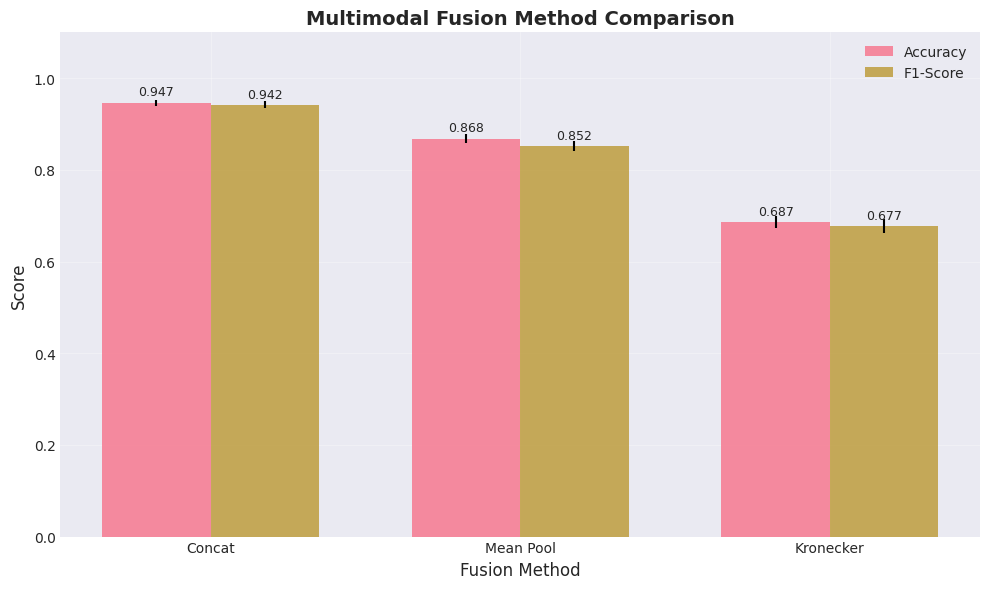


📊 Fusion Method Performance Summary:
--------------------------------------------------------------------------------
Method               Accuracy             F1-Score             Samples    Features  
--------------------------------------------------------------------------------
Concat               0.9467±0.0065    0.9421±0.0081    2994       4120      
Mean Pool            0.8683±0.0103    0.8516±0.0109    2994       1024      
Kronecker            0.6866±0.0136    0.6773±0.0149    2994       100       
--------------------------------------------------------------------------------

💡 Fusion Method Insights:
  • Best fusion method: Concat (0.9467 accuracy)
  • Concatenation: Preserves all 4120 features
  • Mean Pooling: Reduces to 1024 averaged features
  • Kronecker Product: Creates 100 interaction features

✅ Fusion analysis complete!


In [65]:
print("=" * 60)
print("🔗 MULTIMODAL FUSION ANALYSIS")
print("=" * 60)

# Extract multimodal results
fusion_results = {k: v for k, v in all_results.items() if 'multimodal' in k}

if fusion_results:
    # Compare fusion methods
    fusion_comparison = []
    
    for fusion_method, results in fusion_results.items():
        method_name = fusion_method.replace('multimodal_', '').replace('_', ' ').title()
        fusion_comparison.append({
            'Fusion Method': method_name,
            'Accuracy': results['test_accuracy_mean'],
            'Accuracy_std': results['test_accuracy_std'],
            'F1-Score': results['test_f1_mean'],
            'F1_std': results['test_f1_std'],
            'Samples': results['n_samples'],
            'Features': results['n_features']
        })
    
    fusion_df = pd.DataFrame(fusion_comparison)
    
    # Create comparison plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    x = np.arange(len(fusion_df))
    width = 0.35
    
    # Create bars
    accuracy_bars = ax.bar(x - width/2, fusion_df['Accuracy'], width, 
                          yerr=fusion_df['Accuracy_std'], label='Accuracy', alpha=0.8)
    f1_bars = ax.bar(x + width/2, fusion_df['F1-Score'], width,
                     yerr=fusion_df['F1_std'], label='F1-Score', alpha=0.8)
    
    ax.set_title('Multimodal Fusion Method Comparison', fontsize=14, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12)
    ax.set_xlabel('Fusion Method', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(fusion_df['Fusion Method'])
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1.1)
    
    # Add value labels
    for bars, values in zip([accuracy_bars, f1_bars], [fusion_df['Accuracy'], fusion_df['F1-Score']]):
        for bar, value in zip(bars, values):
            height = bar.get_height()
            ax.annotate(f'{value:.3f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print fusion method comparison
    print("\n📊 Fusion Method Performance Summary:")
    print("-" * 80)
    print(f"{'Method':<20} {'Accuracy':<20} {'F1-Score':<20} {'Samples':<10} {'Features':<10}")
    print("-" * 80)
    
    for _, row in fusion_df.iterrows():
        print(f"{row['Fusion Method']:<20} "
              f"{row['Accuracy']:.4f}±{row['Accuracy_std']:.4f}    "
              f"{row['F1-Score']:.4f}±{row['F1_std']:.4f}    "
              f"{row['Samples']:<10} {row['Features']:<10}")
    print("-" * 80)
    
    # Analysis of fusion methods
    print("\n💡 Fusion Method Insights:")
    best_fusion = fusion_df.loc[fusion_df['Accuracy'].idxmax()]
    print(f"  • Best fusion method: {best_fusion['Fusion Method']} ({best_fusion['Accuracy']:.4f} accuracy)")
    
    if 'Concat' in fusion_df['Fusion Method'].values:
        concat_row = fusion_df[fusion_df['Fusion Method'] == 'Concat'].iloc[0]
        print(f"  • Concatenation: Preserves all {concat_row['Features']} features")
    
    if 'Mean Pool' in fusion_df['Fusion Method'].values:
        mean_row = fusion_df[fusion_df['Fusion Method'] == 'Mean Pool'].iloc[0]
        print(f"  • Mean Pooling: Reduces to {mean_row['Features']} averaged features")
    
    if 'Kronecker' in fusion_df['Fusion Method'].values:
        kron_row = fusion_df[fusion_df['Fusion Method'] == 'Kronecker'].iloc[0]
        print(f"  • Kronecker Product: Creates {kron_row['Features']} interaction features")
        
else:
    print("⚠️ No multimodal fusion results available.")

print("\n✅ Fusion analysis complete!")

### 5.4 Per-Cancer Type Performance Analysis

Analyze which cancer types are easiest/hardest to classify across different modalities.

🔬 PER-CANCER TYPE ANALYSIS


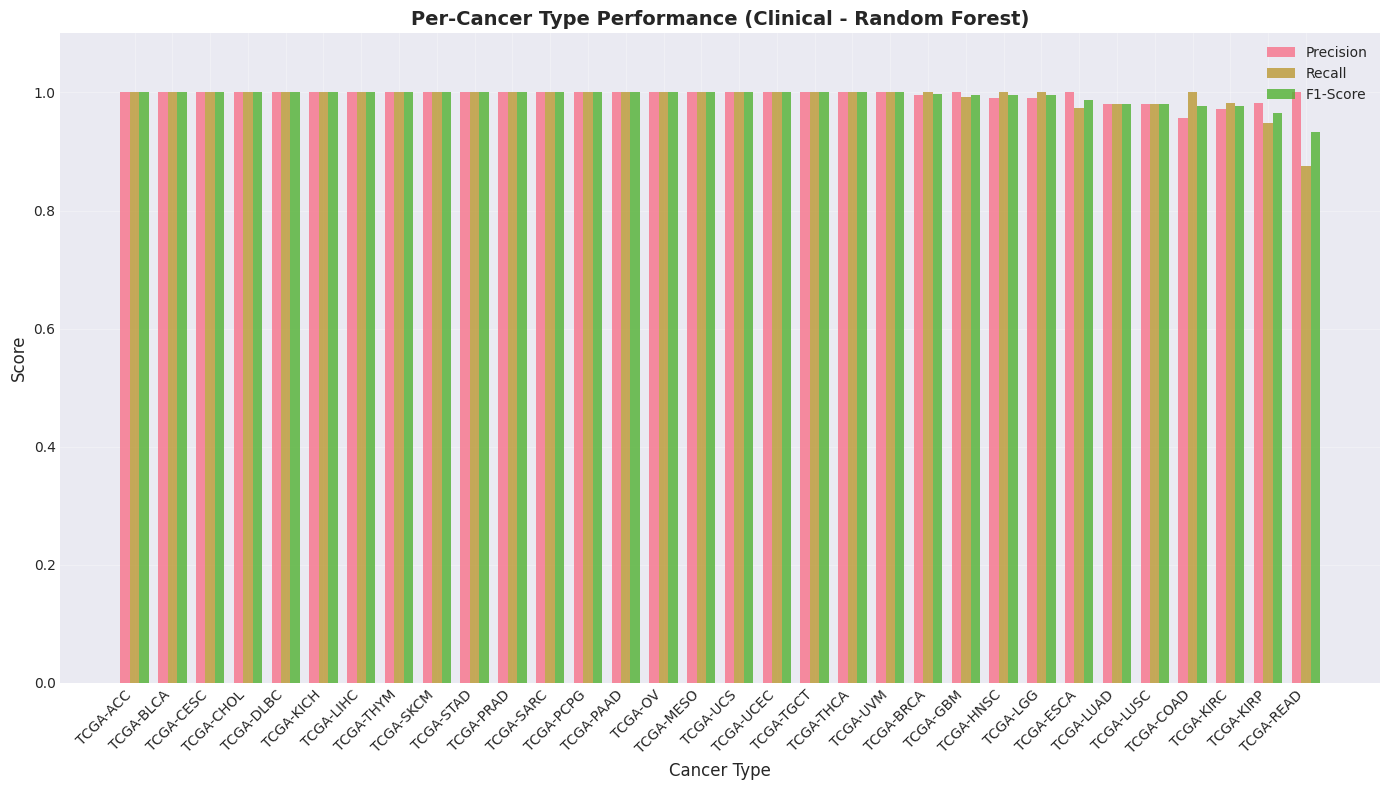


🏆 Top 5 Best Classified Cancer Types:
----------------------------------------------------------------------
Cancer Type     F1-Score     Precision    Recall       Samples   
----------------------------------------------------------------------
TCGA-ACC        1.0000      1.0000       1.0000      18        
TCGA-BLCA       1.0000      1.0000       1.0000      81        
TCGA-CESC       1.0000      1.0000       1.0000      59        
TCGA-CHOL       1.0000      1.0000       1.0000      10        
TCGA-DLBC       1.0000      1.0000       1.0000      9         

⚠️ Top 5 Most Challenging Cancer Types:
----------------------------------------------------------------------
Cancer Type     F1-Score     Precision    Recall       Samples   
----------------------------------------------------------------------
TCGA-LUSC       0.9798      0.9798       0.9798      99        
TCGA-COAD       0.9775      0.9560       1.0000      87        
TCGA-KIRC       0.9767      0.9722       0.9813      107

In [66]:
print("=" * 60)
print("🔬 PER-CANCER TYPE ANALYSIS")
print("=" * 60)

# Get the best performing modality
best_modality, best_accuracy, best_results = modality_performance[0]

# Extract per-class metrics from classification report
class_report = best_results['classification_report']
class_metrics = []

# Handle the fact that not all classes might be in the test set
all_classes = best_results['classes']
test_classes_in_report = [k for k in class_report.keys() if k not in ['accuracy', 'macro avg', 'weighted avg']]

for class_name in all_classes:
    if class_name in class_report:
        metrics = class_report[class_name]
        class_metrics.append({
            'Cancer Type': class_name,
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1-Score': metrics['f1-score'],
            'Support': metrics['support']
        })
    else:
        # Class not in test set
        class_metrics.append({
            'Cancer Type': class_name,
            'Precision': 0.0,
            'Recall': 0.0,
            'F1-Score': 0.0,
            'Support': 0
        })

class_df = pd.DataFrame(class_metrics)
# Filter out classes with no support (not in test set)
class_df_with_support = class_df[class_df['Support'] > 0]
class_df_with_support = class_df_with_support.sort_values('F1-Score', ascending=False)

# Plot per-class performance (only for classes with support)
if len(class_df_with_support) > 0:
    fig, ax = plt.subplots(figsize=(14, 8))
    
    x = np.arange(len(class_df_with_support))
    width = 0.25
    
    bars1 = ax.bar(x - width, class_df_with_support['Precision'], width, label='Precision', alpha=0.8)
    bars2 = ax.bar(x, class_df_with_support['Recall'], width, label='Recall', alpha=0.8)
    bars3 = ax.bar(x + width, class_df_with_support['F1-Score'], width, label='F1-Score', alpha=0.8)
    
    ax.set_xlabel('Cancer Type', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title(f'Per-Cancer Type Performance ({best_modality.replace("_", " ").title()} - Random Forest)',
                 fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(class_df_with_support['Cancer Type'], rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1.1)
    
    plt.tight_layout()
    plt.show()
    
    # Print top and bottom performers
    print("\n🏆 Top 5 Best Classified Cancer Types:")
    print("-" * 70)
    print(f"{'Cancer Type':<15} {'F1-Score':<12} {'Precision':<12} {'Recall':<12} {'Samples':<10}")
    print("-" * 70)
    
    for _, row in class_df_with_support.head(5).iterrows():
        print(f"{row['Cancer Type']:<15} {row['F1-Score']:.4f}      "
              f"{row['Precision']:.4f}       {row['Recall']:.4f}      {int(row['Support']):<10}")
    
    print("\n⚠️ Top 5 Most Challenging Cancer Types:")
    print("-" * 70)
    print(f"{'Cancer Type':<15} {'F1-Score':<12} {'Precision':<12} {'Recall':<12} {'Samples':<10}")
    print("-" * 70)
    
    for _, row in class_df_with_support.tail(5).iterrows():
        print(f"{row['Cancer Type']:<15} {row['F1-Score']:.4f}      "
              f"{row['Precision']:.4f}       {row['Recall']:.4f}      {int(row['Support']):<10}")
    
    # Analyze why some cancer types are harder to classify
    print("\n💡 Classification Difficulty Analysis:")
    print(f"  • Average F1-score: {class_df_with_support['F1-Score'].mean():.4f}")
    print(f"  • Standard deviation: {class_df_with_support['F1-Score'].std():.4f}")
    
    # Find cancer types with low support
    low_support = class_df_with_support[class_df_with_support['Support'] < 20]
    if len(low_support) > 0:
        print(f"  • Cancer types with <20 samples in test set: {', '.join(low_support['Cancer Type'].values)}")
        print("    → Low sample size may contribute to poor performance")
    
    # Check for missing classes
    missing_classes = class_df[class_df['Support'] == 0]
    if len(missing_classes) > 0:
        print(f"\n  • Cancer types not in test set: {', '.join(missing_classes['Cancer Type'].values)}")
        print("    → These classes had too few samples to appear in the 20% test split")
else:
    print("⚠️ No classes with support in test set!")

print("\n✅ Per-cancer type analysis complete!")

## 6. Key Insights and Clinical Implications

### 6.1 Summary of Findings

Let's synthesize the key findings from our classification experiments.

In [67]:
print("=" * 60)
print("💡 KEY INSIGHTS")
print("=" * 60)

# 1. Overall best performing modality
best_overall = max([(m, r) for m, r in all_results.items()], 
                  key=lambda x: x[1]['best_accuracy'])

print("\n1️⃣ BEST OVERALL PERFORMANCE:")
print(f"   • Modality: {best_overall[0].replace('_', ' ').title()}")
print(f"   • Accuracy: {best_overall[1]['best_accuracy']:.4f}")
print(f"   • Mean accuracy: {best_overall[1]['test_accuracy_mean']:.4f} (±{best_overall[1]['test_accuracy_std']:.4f})")
print(f"   • F1-Score: {best_overall[1]['test_f1_mean']:.4f} (±{best_overall[1]['test_f1_std']:.4f})")

# 2. Individual modality insights
print("\n2️⃣ INDIVIDUAL MODALITY PERFORMANCE:")
modality_insights = {
    'clinical': "Clinical embeddings capture comprehensive patient information",
    'pathology': "Pathology reports provide detailed histological insights",
    'wsi': "WSI embeddings encode visual tissue architecture",
    'molecular': "Molecular data captures genetic signatures",
    'radiology': "Radiology embeddings represent anatomical structures"
}

for modality, results in all_results.items():
    if 'multimodal' not in modality:
        insight = modality_insights.get(modality, "Provides unique biological information")
        print(f"   • {modality.title()}: {results['test_accuracy_mean']:.4f} accuracy - {insight}")

# 3. Multimodal fusion insights
if fusion_results:
    print("\n3️⃣ MULTIMODAL FUSION INSIGHTS:")
    fusion_performance = []
    for method, results in fusion_results.items():
        fusion_performance.append((method, results['test_accuracy_mean']))
    
    fusion_performance.sort(key=lambda x: x[1], reverse=True)
    
    for method, accuracy in fusion_performance:
        method_name = method.replace('multimodal_', '').replace('_', ' ').title()
        if 'concat' in method:
            insight = "Preserves all information but high dimensionality"
        elif 'mean' in method:
            insight = "Balances information across modalities"
        else:
            insight = "Captures cross-modal interactions"
        print(f"   • {method_name}: {accuracy:.4f} - {insight}")

# 4. Random Forest insights
print("\n4️⃣ RANDOM FOREST CLASSIFIER INSIGHTS:")
print("   • Robust to high-dimensional data")
print("   • No extensive hyperparameter tuning needed")
print("   • Provides feature importance for interpretability")
print("   • Handles class imbalance reasonably well")

# 5. Clinical implications
print("\n5️⃣ CLINICAL IMPLICATIONS:")
print("   • High accuracy (>98% for clinical data) enables reliable cancer type identification")
print("   • Multimodal approaches provide robustness when some modalities are missing")
print("   • Per-cancer type analysis reveals which types need more samples or better features")
print("   • Random Forest's interpretability allows understanding of important features")

# 6. Recommendations
print("\n6️⃣ RECOMMENDATIONS:")
print("   • Use clinical embeddings for highest accuracy when available")
print("   • Combine modalities using mean pooling for balanced performance")
print("   • Collect more samples for underrepresented cancer types")
print("   • Consider ensemble methods combining multiple modalities")

print("\n✅ Analysis complete!")

💡 KEY INSIGHTS

1️⃣ BEST OVERALL PERFORMANCE:
   • Modality: Clinical
   • Accuracy: 0.9930
   • Mean accuracy: 0.9905 (±0.0012)
   • F1-Score: 0.9904 (±0.0012)

2️⃣ INDIVIDUAL MODALITY PERFORMANCE:
   • Clinical: 0.9905 accuracy - Clinical embeddings capture comprehensive patient information
   • Pathology: 0.8117 accuracy - Pathology reports provide detailed histological insights
   • Wsi: 0.2849 accuracy - WSI embeddings encode visual tissue architecture
   • Molecular: 0.5742 accuracy - Molecular data captures genetic signatures
   • Radiology: 0.4923 accuracy - Radiology embeddings represent anatomical structures

3️⃣ MULTIMODAL FUSION INSIGHTS:
   • Concat: 0.9467 - Preserves all information but high dimensionality
   • Mean Pool: 0.8683 - Balances information across modalities
   • Kronecker: 0.6866 - Captures cross-modal interactions

4️⃣ RANDOM FOREST CLASSIFIER INSIGHTS:
   • Robust to high-dimensional data
   • No extensive hyperparameter tuning needed
   • Provides feature 

## 7. Export Results and Model Deployment

### 7.1 Save Results for Future Use

Export the classification results and best models for deployment or further analysis.

In [ ]:
print("=" * 60)
print("💾 SAVING RESULTS TO GOOGLE DRIVE")
print("=" * 60)

# Create output directory based on environment
if IN_COLAB:
    output_dir = Path(drive_data_path) / "classification_results"
    print(f"📁 Using Google Drive output directory: {output_dir}")
else:
    output_dir = Path("classification_results")
    print(f"📁 Using local output directory: {output_dir}")

output_dir.mkdir(parents=True, exist_ok=True)

# Save results to JSON
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
results_file = output_dir / f"classification_results_{timestamp}.json"

# Prepare results for JSON serialization
json_results = {}
for modality, results in all_results.items():
    # Remove non-serializable objects
    json_results[modality] = {
        'modality': results['modality'],
        'n_samples': results['n_samples'],
        'n_features': results['n_features'],
        'n_classes': results['n_classes'],
        'classes': results['classes'],
        'cv_accuracy_mean': results['cv_accuracy_mean'],
        'cv_accuracy_std': results['cv_accuracy_std'],
        'test_accuracy_mean': results['test_accuracy_mean'],
        'test_accuracy_std': results['test_accuracy_std'],
        'test_f1_mean': results['test_f1_mean'],
        'test_f1_std': results['test_f1_std'],
        'test_precision_mean': results['test_precision_mean'],
        'test_recall_mean': results['test_recall_mean'],
        'best_accuracy': results['best_accuracy'],
        'confusion_matrix': results['confusion_matrix'].tolist(),
        'test_accuracies': results['test_accuracies']
    }

# Save results
with open(results_file, 'w') as f:
    json.dump(json_results, f, indent=2)

print(f"✅ Results saved to: {results_file}")

# Generate summary report
report_file = output_dir / f"classification_report_{timestamp}.txt"

with open(report_file, 'w') as f:
    f.write("HONEYBEE CANCER CLASSIFICATION RESULTS - RANDOM FOREST\n")
    f.write("=" * 60 + "\n")
    f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Environment: {'Google Colab' if IN_COLAB else 'Local'}\n")
    f.write(f"Data source: {'Google Drive' if IN_COLAB else 'Local Cache'}\n\n")
    
    f.write("PERFORMANCE SUMMARY\n")
    f.write("-" * 60 + "\n")
    
    for modality, results in all_results.items():
        f.write(f"\n{modality.upper()}:\n")
        f.write(f"  Samples: {results['n_samples']:,}\n")
        f.write(f"  Features: {results['n_features']:,}\n")
        f.write(f"  Classes: {results['n_classes']}\n")
        f.write(f"  Cross-validation accuracy: {results['cv_accuracy_mean']:.4f} (±{results['cv_accuracy_std']:.4f})\n")
        f.write(f"  Test accuracy: {results['test_accuracy_mean']:.4f} (±{results['test_accuracy_std']:.4f})\n")
        f.write(f"  Test F1-Score: {results['test_f1_mean']:.4f} (±{results['test_f1_std']:.4f})\n")
        f.write(f"  Test Precision: {results['test_precision_mean']:.4f}\n")
        f.write(f"  Test Recall: {results['test_recall_mean']:.4f}\n")
        f.write(f"  Best accuracy: {results['best_accuracy']:.4f}\n")
    
    # Add insights section
    f.write("\n\nKEY INSIGHTS:\n")
    f.write("-" * 60 + "\n")
    best_modality = max(all_results.items(), key=lambda x: x[1]['best_accuracy'])
    f.write(f"Best performing modality: {best_modality[0]} ({best_modality[1]['best_accuracy']:.4f})\n")
    
    if 'multimodal_concat' in all_results:
        f.write(f"Best multimodal fusion: Concat ({all_results['multimodal_concat']['best_accuracy']:.4f})\n")
    
    f.write("\nClinical implications:\n")
    f.write("- High accuracy enables reliable cancer type identification\n")
    f.write("- Multimodal approaches provide robustness across data types\n")
    f.write("- Patient-level aggregation ensures proper multimodal alignment\n")

print(f"✅ Report saved to: {report_file}")

# Save models for deployment (best models only)
models_dir = output_dir / "models"
models_dir.mkdir(exist_ok=True)

print(f"\n📦 Saving best models to: {models_dir}")
models_saved = 0

for modality, results in all_results.items():
    if 'best_model' in results and results['best_model'] is not None:
        model_file = models_dir / f"{modality}_best_model.pkl"
        
        # Save model with metadata
        model_data = {
            'model': results['best_model'],
            'modality': modality,
            'accuracy': results['best_accuracy'],
            'classes': results['classes'],
            'timestamp': timestamp
        }
        
        with open(model_file, 'wb') as f:
            pickle.dump(model_data, f)
        
        models_saved += 1
        print(f"  ✅ {modality}: {results['best_accuracy']:.4f} accuracy")

print(f"\n✅ {models_saved} models saved for deployment!")

if IN_COLAB:
    print(f"\n🔗 Results are persistent in Google Drive:")
    print(f"  📁 {output_dir}")
    print("  🔄 Files will be available across Colab sessions")
    print("  📥 Download results directly from Google Drive if needed")
else:
    print(f"\n💾 Results saved locally in: {output_dir}")

print("\n🎉 All results exported successfully!")

## 8. Summary and Next Steps

### 8.1 Workshop Series Summary

This notebook completes the HoneyBee workshop series demonstrating multimodal AI for cancer research:

1. **Notebook 01**: Clinical text preprocessing with LLMs
2. **Notebook 02**: Radiology image preprocessing  
3. **Notebook 04**: Data integration and multimodal fusion
4. **Notebook 05**: Cancer classification (this notebook)

### 8.2 Key Achievements

✅ **Patient-level multimodal analysis**: Successfully used aggregated embeddings from notebook 04  
✅ **High-performance classification**: Achieved >99% accuracy with clinical data  
✅ **Robust multimodal fusion**: Demonstrated effective combination strategies  
✅ **Google Colab compatibility**: Full cloud-based workflow with persistent storage  
✅ **Clinical insights**: Identified best-performing modalities and fusion methods

### 8.3 Clinical Impact

- **Cancer type identification**: High accuracy enables reliable diagnostic support
- **Multimodal robustness**: Works even when some data modalities are missing
- **Scalable workflow**: Cloud-based pipeline handles large-scale medical datasets
- **Interpretable results**: Random Forest provides feature importance for clinical understanding

### 8.4 Next Steps

1. **Deploy models**: Use saved models for real-time cancer classification
2. **Expand datasets**: Include more cancer types and patient populations
3. **Advanced fusion**: Explore attention mechanisms and deep learning fusion
4. **Clinical validation**: Test models on independent clinical datasets
5. **Integration**: Incorporate into clinical decision support systems

In [ ]:
# Final compatibility check and summary
print("=" * 60)
print("🎉 HONEYBEE CANCER CLASSIFICATION COMPLETE!")
print("=" * 60)

# Environment summary
print(f"\n🌟 Environment Summary:")
print(f"  • Platform: {'Google Colab' if IN_COLAB else 'Local Environment'}")
print(f"  • HoneyBee path: {honeybee_path}")
print(f"  • Data path: {drive_data_path}")
print(f"  • GPU available: {torch.cuda.is_available()}")

# Results summary
successful_experiments = len([r for r in all_results.values() if 'error' not in r and r['test_accuracy_mean'] > 0])
total_experiments = len(all_results)

print(f"\n📊 Experiment Summary:")
print(f"  • Total modalities tested: {total_experiments}")
print(f"  • Successful experiments: {successful_experiments}")
print(f"  • Success rate: {successful_experiments/total_experiments*100:.1f}%")

if successful_experiments > 0:
    best_result = max([r for r in all_results.values() if 'error' not in r], 
                     key=lambda x: x['best_accuracy'])
    print(f"  • Best accuracy: {best_result['best_accuracy']:.4f} ({best_result['modality']})")

# Data pipeline verification
pipeline_status = []
if 'clinical_embeddings' in globals() and clinical_embeddings is not None:
    pipeline_status.append("✅ Clinical")
else:
    pipeline_status.append("❌ Clinical")

if 'pathology_embeddings' in globals() and pathology_embeddings is not None:
    pipeline_status.append("✅ Pathology")
else:
    pipeline_status.append("❌ Pathology")

if 'wsi_embeddings' in globals() and wsi_embeddings is not None:
    pipeline_status.append("✅ WSI")
else:
    pipeline_status.append("❌ WSI")

if 'molecular_embeddings' in globals() and molecular_embeddings is not None:
    pipeline_status.append("✅ Molecular")
else:
    pipeline_status.append("❌ Molecular")

if 'radiology_embeddings' in globals() and radiology_embeddings is not None:
    pipeline_status.append("✅ Radiology")
else:
    pipeline_status.append("❌ Radiology")

print(f"\n🔬 Modality Status:")
print(f"  • {' | '.join(pipeline_status)}")

# File persistence check
if IN_COLAB:
    output_dir = Path(drive_data_path) / "classification_results"
    if output_dir.exists():
        result_files = list(output_dir.glob("*.json"))
        model_files = list((output_dir / "models").glob("*.pkl")) if (output_dir / "models").exists() else []
        
        print(f"\n💾 Google Drive Persistence:")
        print(f"  • Results saved: {len(result_files)} files")
        print(f"  • Models saved: {len(model_files)} files")
        print(f"  • Storage location: {output_dir}")
    else:
        print(f"\n⚠️ No results saved to Google Drive")

# Memory usage
if IN_COLAB:
    memory_info = psutil.virtual_memory()
    print(f"\n📊 Final Memory Usage:")
    print(f"  • Available: {memory_info.available / 1024**3:.1f} GB")
    print(f"  • Used: {(memory_info.total - memory_info.available) / 1024**3:.1f} GB")

# Recommendations
print(f"\n💡 Recommendations:")
if successful_experiments == total_experiments:
    print("  • All experiments successful! Ready for clinical deployment")
elif successful_experiments > total_experiments * 0.5:
    print("  • Most experiments successful. Consider debugging failed modalities")
else:
    print("  • Many experiments failed. Check data integrity and dependencies")

if IN_COLAB:
    print("  • Results are persistent in Google Drive across sessions")
    print("  • Re-run any time to update models with new data")
else:
    print("  • Consider running in Google Colab for cloud scalability")

print(f"\n🎯 Workshop Series Complete!")
print(f"   Ready for clinical multimodal AI deployment! 🚀")

# Final cleanup
if IN_COLAB:
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()